## Load

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval
from tqdm.auto import tqdm
import ray
import os

np.random.seed=42

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/Users/rco/OneDrive/ITA/Mestrado/2021_TE-282 - Meta heurísticas/P-MetaHeuristica/p_metaheuristic/data/log


In [2]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

In [3]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}

uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [4]:
@ray.remote
def import_logs(filename):
    try:
        file_path = Path(LOG_PATH, filename)
        df = pd.read_csv(file_path, low_memory=False)
        df['filename'] = filename
        df.loc[df[-1:].index, 'last_iter'] = 1
    except:
        print(filename)

    return df

futures = [import_logs.remote(filename) for filename in os.listdir(LOG_PATH) if filename != '.DS_Store']
dfs = ray.get(futures)


(import_logs pid=4792) 


In [5]:
all_data = pd.concat(dfs, ignore_index=True)
all_data.reset_index(drop=True, inplace=True)
print(all_data.shape)
best_data = all_data[all_data.last_iter==1]
print(best_data.shape)

(2187000, 25)
(2187, 25)


## Curvas de Aprendizado

### Mem. Size | Mem. Consider

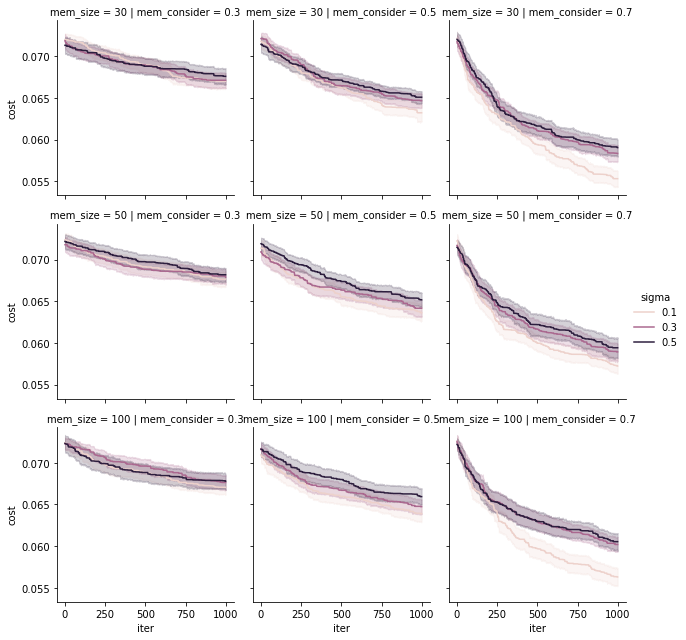

In [7]:
sns.relplot(data=all_data, x='iter', y='cost', row='mem_size', col='mem_consider', kind='line', height=3, hue='sigma')

### PAR Min | Max

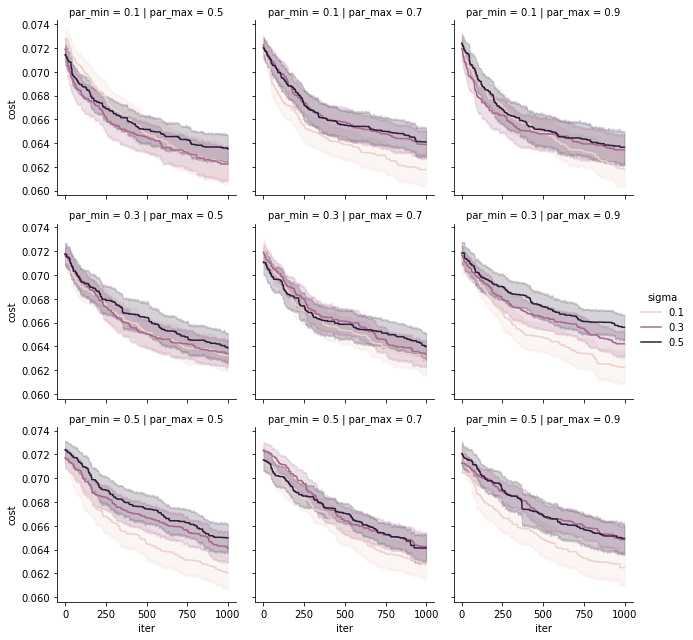

In [8]:
sns.relplot(data=all_data, x='iter', y='cost', row='par_min', col='par_max', kind='line', height=3, hue='sigma')

### BW Min | Max

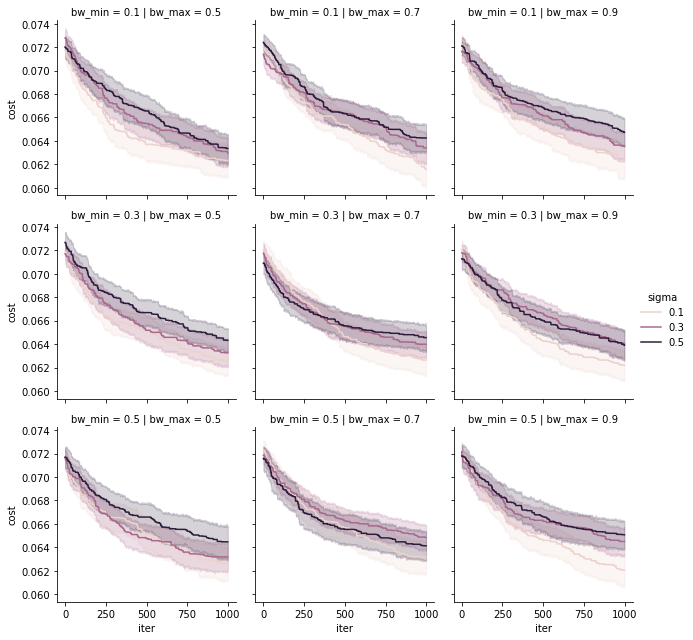

In [9]:
sns.relplot(data=all_data, x='iter', y='cost', row='bw_min', col='bw_max', kind='line', height=3, hue='sigma')

## Risco vs Retorno

### Mem. Size | Mem. Consider

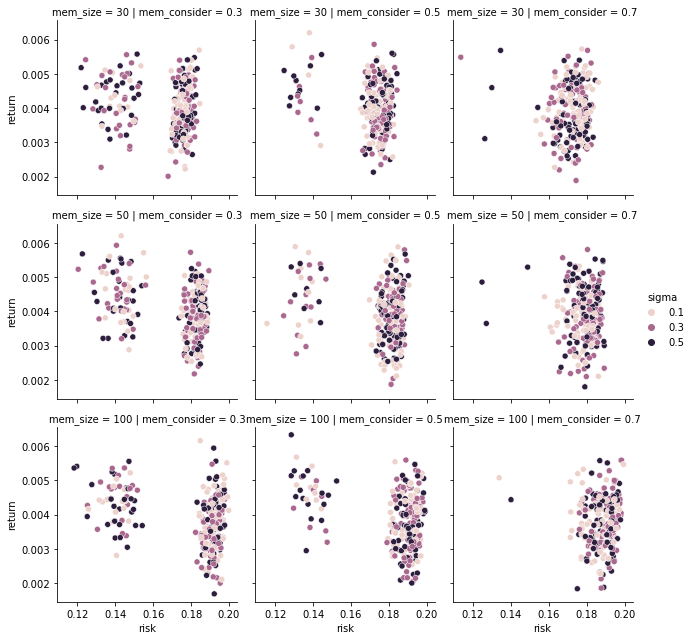

In [13]:
sns.relplot(data=best_data, x='risk', y='return', row='mem_size', col='mem_consider', kind='scatter', height=3, hue='sigma')

### PAR Min | Max

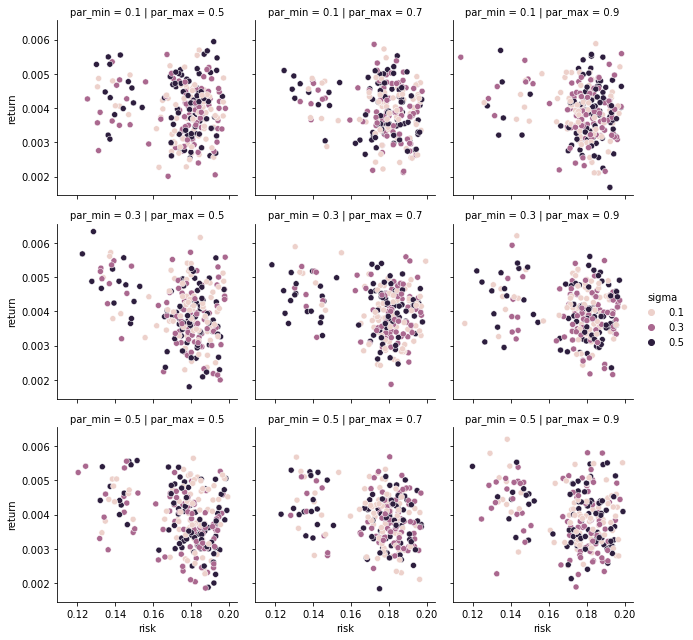

In [15]:
sns.relplot(data=best_data, x='risk', y='return', row='par_min', col='par_max', kind='scatter', height=3, hue='sigma')

### BW Min | Max

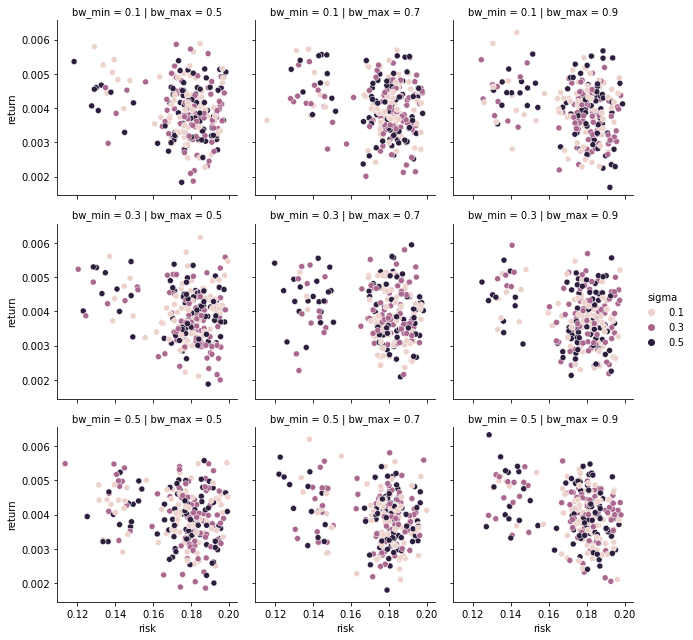

In [16]:
sns.relplot(data=best_data, x='risk', y='return', row='bw_min', col='bw_max', kind='scatter', height=3, hue='sigma')

## Fronteira de Eficiência

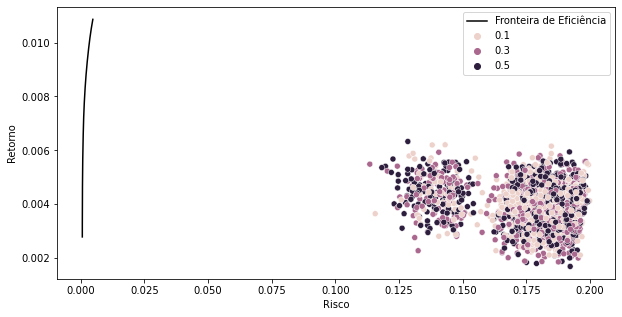

In [11]:
data = best_data
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.scatterplot(data=data, x='risk', y='return', hue='sigma')
plt.ylabel("Retorno")
plt.xlabel("Risco")
plt.legend()

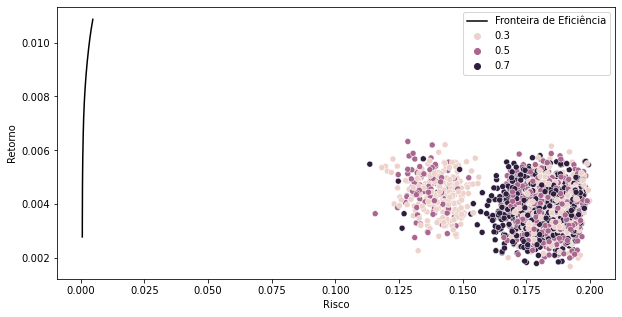

In [17]:
data = best_data
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.scatterplot(data=data, x='risk', y='return', hue='mem_consider')
plt.ylabel("Retorno")
plt.xlabel("Risco")
plt.legend()

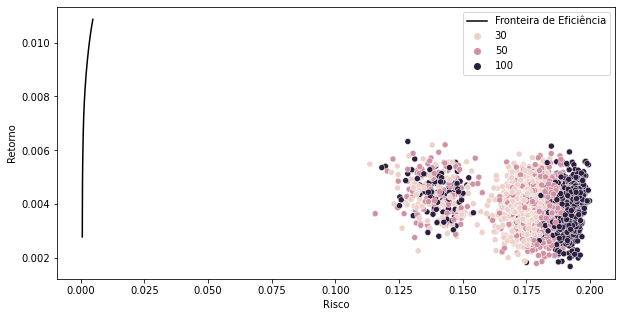

In [18]:
data = best_data
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.scatterplot(data=data, x='risk', y='return', hue='mem_size')
plt.ylabel("Retorno")
plt.xlabel("Risco")
plt.legend()